In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
pip install visualkeras

     |████████████████████████████████| 992 kB 4.4 MB/s 


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import visualkeras


In [ ]:
fields = [
    'img',
    'nose',
    'left_eye',
    'right_eye',
    'left_ear',
    'right_ear',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle']

kpts_paths = ['/content/drive/MyDrive/GDP/interaction_videos/kpts/punching.csv',
              '/content/drive/MyDrive/GDP/interaction_videos/kpts/kicking.csv',
              '/content/drive/MyDrive/GDP/interaction_videos/kpts/pushing.csv',
              '/content/drive/MyDrive/GDP/interaction_videos/kpts/neutral.csv']

kpts_paths2 = ['/content/drive/MyDrive/GDP/interaction_videos/fight.csv',
              '/content/drive/MyDrive/GDP/interaction_videos/normal.csv']
classes = {
    0:'punching',
    1:'kicking',
    2:'pushing',
    3:'neutral'
}

In [ ]:
def special_normalisation(keypoint_vector):
  end_vector = [0]*len(keypoint_vector)
  new_origin = keypoint_vector[0], keypoint_vector[1]
  for k in range(0, len(keypoint_vector), 2):
    end_vector[k] = keypoint_vector[k] - new_origin[0]
    end_vector[k+1] = keypoint_vector[k+1] - new_origin[1]
    #keypoint_vector[k] -= new_origin[0]
    #keypoint_vector[k+1] -= new_origin[1]
  return end_vector

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')> 0.987):
      print("\nReached 98.7% accuracy so cancelling training!")
      self.model.stop_training = True

def summarize_diagnostics(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(acc, 'r', label='Training accuracy')
  plt.plot(val_acc, 'b', label='Test accuracy')
  plt.title('Training and Test accuracy')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

  plt.plot(loss, 'r', label='Training Loss function')
  plt.plot(val_loss, 'b', label='Test Loss function')
  plt.title('Training and Test loss function')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="/content/t",
    histogram_freq=2,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq=500,
    profile_batch=2,
    embeddings_freq=2,
    embeddings_metadata=None,
)
def field_transform(fields):
  test = fields[0]
  for s in fields[1:]:
    test += ','+s+'_x,'+s+'_y'
  return test

In [ ]:
def field_transform2(fields):
  to_return = [fields[0]]
  for s in fields[1:]:
    to_return.append(s+'_x')
    to_return.append(s+'_y')
  to_return.append('label')
  return to_return

In [ ]:
def csv_correction(csv_path, fields):
  with open(csv_path, 'r') as f:
    string = f.read()
    #string = 'img,left_eye,right_eye,left_ear,right_ear,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle\n'+string
    string = field_transform(fields)+'\n'+string
  with open(csv_path, 'w') as f:
    f.write(string)

In [ ]:
#for path in kpts_paths2:
#  csv_correction(path, fields)

In [ ]:

dfs = []
#0:punch, 1:kick, 2:push, 3:neutral
for idx, _path in enumerate(kpts_paths2):
  kpt_data = pd.read_csv(_path)
  
  if idx in [0]:
    kpt_data['label']=1
  else:
    kpt_data['label']=0
  
  #kpt_data['label'] = idx
  
  dfs.append(kpt_data)
  

In [ ]:
DATA = pd.concat(dfs)
DATA

,img,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
0,00.jpg,0.0,0.0,-0.017361,-0.019731,-0.034722,-0.013154,-0.026042,0.000000,-0.104167,...,0.295961,0.546875,0.019731,0.312500,0.552461,0.789930,-0.144692,0.295139,0.769499,1
1,0008.jpg,0.0,0.0,0.065999,-0.013021,-0.022000,-0.032552,0.131998,-0.013021,-0.054999,...,0.338542,0.011000,0.546875,-0.033000,0.572917,0.076999,0.813802,0.131998,0.735677,1
2,0017.jpg,0.0,0.0,0.008681,-0.020741,-0.034722,-0.027654,0.026042,-0.006914,-0.104167,...,0.463207,-0.173611,0.808885,-0.277778,0.815798,-0.273438,1.068143,-0.377604,1.068143,1
3,00171.jpg,0.0,0.0,0.028199,-0.026042,-0.056398,-0.019531,0.070497,-0.052083,-0.211492,...,0.351562,0.126895,0.625000,-0.267890,0.592448,-0.084597,0.839844,-0.507581,0.878906,1
4,0022.jpg,0.0,0.0,0.026042,-0.034246,-0.034722,-0.025684,0.043403,-0.042807,-0.086806,...,0.291090,0.295139,0.196914,-0.104167,0.513688,0.546875,0.188352,-0.069444,0.779093,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,61081.jpg,0.0,0.0,-0.012349,-0.078125,-0.148182,-0.084635,-0.691518,-0.026042,-0.666821,...,0.214844,-0.259319,-0.104167,-0.728564,-0.286458,-0.197577,0.449219,-0.358108,0.449219,0
366,7101.jpg,0.0,0.0,0.086065,-0.013021,-0.086065,-0.019531,0.172130,0.000000,-0.258194,...,0.377604,-0.114753,0.585938,-0.487701,0.579427,-0.200818,0.774740,-0.631142,0.774740,0
367,71081.jpg,0.0,0.0,0.054767,-0.026042,-0.091278,-0.026042,0.127790,-0.013021,-0.328602,...,0.690104,0.155173,1.012370,-0.319474,1.012370,0.301218,1.012370,-0.282963,1.012370,0
368,7115.png,0.0,0.0,0.068513,-0.013021,-0.022838,-0.026042,0.342567,-0.039062,-0.045676,...,0.410156,0.296891,0.683594,0.182702,0.683594,0.342567,0.846354,0.342567,0.820312,0


In [ ]:
DATA2 = DATA.sample(frac=1, random_state=41)
DATA2

,img,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
250,0Colour 404.png,0.0,0.0,0.058452,-0.019531,-0.043839,-0.019531,0.146129,0.013021,-0.131516,...,0.598958,0.204580,0.878906,-0.409161,0.885417,0.284951,0.979818,-0.533370,0.979818,0
302,3009.jpg,0.0,0.0,0.026042,-0.027872,0.000000,-0.027872,0.138889,-0.020904,0.008681,...,0.334458,-0.190972,0.689820,-0.477431,0.264780,-0.199653,0.891889,-0.737847,0.027872,1
178,0Colour 306.png,0.0,0.0,0.049483,-0.019531,-0.032988,-0.019531,0.115460,0.006510,-0.115460,...,0.423177,0.230919,0.638021,-0.280402,0.625000,0.280402,0.839844,-0.379368,0.846354,0
190,1027.jpg,0.0,0.0,0.037901,-0.058594,-0.066327,-0.081380,0.009475,-0.081380,-0.227408,...,0.332031,0.075803,0.657552,-0.435865,0.638021,-0.511667,0.930989,-0.511667,0.950521,1
106,0Colour 210.png,0.0,0.0,0.060147,-0.013021,-0.060147,-0.013021,0.140342,0.013021,-0.140342,...,0.455729,0.180440,0.696615,-0.320782,0.696615,0.180440,0.917969,-0.300733,0.917969,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0Colour 184.png,0.0,0.0,0.091956,-0.019531,-0.045978,-0.026042,0.160923,0.006510,-0.137934,...,0.429688,0.183912,0.664062,-0.367824,0.664062,0.160923,0.878906,-0.367824,0.872396,0
278,0Colour 464.png,0.0,0.0,0.044623,-0.019531,-0.044623,-0.019531,0.104121,0.006510,-0.089247,...,0.416667,0.178494,0.625000,-0.297490,0.625000,0.267741,0.839844,-0.401611,0.826823,0
243,1136.png,0.0,0.0,0.026042,-0.007722,0.000000,-0.023167,0.060764,0.000000,-0.043403,...,0.038612,-0.173611,0.494240,-0.434028,0.247120,0.121528,0.370680,-0.651042,0.656412,1
321,6008.jpg,0.0,0.0,0.112847,-0.132063,-0.147569,-0.152381,0.217014,-0.010159,-0.355903,...,0.253968,-0.312500,0.396190,-0.321181,0.335237,-0.312500,0.446984,-0.295139,0.375873,1


punching


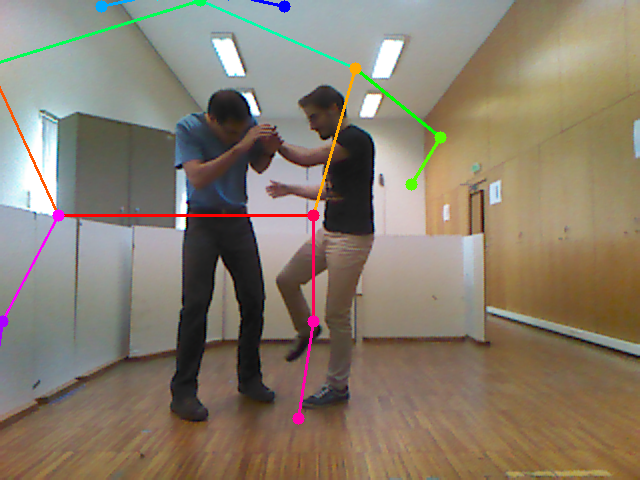

In [ ]:
import cv2
import random as rd
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/GDP/interaction_videos/isr_lcas/bis/kicking/a05_s02_00139_color.png')
k=rd.randint(0, 300)
vector = DATA2.iloc[k][[x for x in DATA2.columns if x not in ['img', 'label']]].to_numpy()
print(classes[DATA2.iloc[k]['label']])
SKELETON = [
    [1,3],[1,0],[2,4],[2,0],[0,5],[0,6],[5,7],[7,9],[6,8],[8,10],[5,11],[6,12],[11,12],[11,13],[13,15],[12,14],[14,16]
]
CocoColors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

x = [ vector[n]*640+200 for n in range(0,len(vector), 2)]
y = [ vector[n]*480 for n in range(1,len(vector), 2)]
for i in range(len(SKELETON)):
    kpt_a, kpt_b = SKELETON[i][0], SKELETON[i][1]
    x_a, y_a = x[kpt_a],y[kpt_a]
    x_b, y_b = x[kpt_b],y[kpt_b]
    cv2.circle(img, (int(x_a), int(y_a)), 6, CocoColors[i], -1)
    cv2.circle(img, (int(x_b), int(y_b)), 6, CocoColors[i], -1)
    cv2.line(img, (int(x_a), int(y_a)), (int(x_b), int(y_b)), CocoColors[i], 2)
cv2_imshow(img)


In [ ]:
import matplotlib.pyplot as plt
SKELETON = [
    [1,3],[1,0],[2,4],[2,0],[0,5],[0,6],[5,7],[7,9],[6,8],[8,10],[5,11],[6,12],[11,12],[11,13],[13,15],[12,14],[14,16]
]
CocoColors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
def color_conv(col_l):
  return_color = [0]*3
  for k in range(len(col_l)):
    return_color[k] = col_l[k]/255
  return return_color
vector = special_normalisation(X[0])
x = [ vector[n]*100 for n in range(0,len(vector), 2)]
y = [ vector[n]*100 for n in range(1,len(vector), 2)]

for i in range(len(SKELETON)):
    kpt_a, kpt_b = SKELETON[i][0], SKELETON[i][1]
    x_a, y_a = x[kpt_a],y[kpt_a]
    x_b, y_b = x[kpt_b],y[kpt_b]
    #cv2.circle(img, (int(x_a), int(y_a)), 6, CocoColors[i], -1)
    #cv2.circle(img, (int(x_b), int(y_b)), 6, CocoColors[i], -1)
    plt.plot([int(x_a), int(x_b)], [int(y_a), int(y_b)],color=color_conv(CocoColors[i])) 
    #cv2.line(img, (int(x_a), int(y_a)), (int(x_b), int(y_b)), CocoColors[i], 2)
plt.show()

In [ ]:
X, Y = DATA2[[x for x in DATA2.columns if x not in ['img', 'label']]].to_numpy(), DATA2['label'].to_numpy()
t_ratio = int(0.8*len(X))
v_ratio = int(0.9*len(X))
X_train = X[:t_ratio]
Y_train = Y[:t_ratio]
X_test = X[t_ratio:v_ratio]
Y_test = Y[t_ratio:v_ratio]
X_valid= X[v_ratio:]
Y_valid = Y[v_ratio:]

In [ ]:
def special_normalisation(keypoint_vector):
  end_vector = [0]*len(keypoint_vector)
  new_origin = keypoint_vector[0], keypoint_vector[1]
  for k in range(0, len(keypoint_vector), 2):
    end_vector[k] = keypoint_vector[k] - new_origin[0]
    end_vector[k+1] = keypoint_vector[k+1] - new_origin[1]
    #keypoint_vector[k] -= new_origin[0]
    #keypoint_vector[k+1] -= new_origin[1]
  return end_vector


In [ ]:
def flip_kpt(kpt_vector):
  end_vector = [kpt_vector[k]*(-1)**(k+1) for k in range(len(kpt_vector))]
  return end_vector
print([2,848,23,15,54,545], flip_kpt([2,848,23,15,54,545]))

[2, 848, 23, 15, 54, 545] [-2, 848, -23, 15, -54, 545]


In [ ]:
def flip_df(ddf):
  to_df = [['']+[0.0]*34+[0] for k in range(len(ddf))]
  df = pd.DataFrame(to_df, columns=field_transform2(fields))
  for k in range(len(ddf)):
    entry = ddf.iloc[k].values
    img, vector, lab = entry[0], entry[1:-1], entry[-1]
    vector = flip_kpt(vector)
    to_df[k] = [img]+vector+[lab]
  return to_df

def spe_norm_df(ddf):
  to_df = [['']+[0.0]*34+[0] for k in range(len(ddf))]
  df = pd.DataFrame(to_df, columns=field_transform2(fields))
  for k in range(len(ddf)):
    entry = ddf.iloc[k].values
    img, vector, lab = entry[0], entry[1:-1], entry[-1]
    vector = special_normalisation(vector)
    to_df[k] = [img]+vector+[lab]
  return to_df
spe_norm_df(DATA)[0]

In [ ]:

DATA_f = pd.DataFrame(flip_df(DATA2), columns=field_transform2(fields))

In [ ]:
DDATA = pd.concat((DATA2, DATA_f))
DATA2 = DDATA.sample(frac=1, random_state=41)


In [ ]:
len(DDATA)

1386

In [ ]:
X, Y = DATA2[[x for x in DATA2.columns if x not in ['img', 'label']]].to_numpy(), DATA2['label'].to_numpy()

t_ratio = int(0.8*len(X))
v_ratio = int(0.9*len(X))
X_train = X[:t_ratio]
Y_train = Y[:t_ratio]
X_test = X[t_ratio:v_ratio]
Y_test = Y[t_ratio:v_ratio]
X_valid= X[v_ratio:]
Y_valid = Y[v_ratio:]

In [ ]:
model = tf.keras.models.Sequential([
                                     
                                    tf.keras.layers.Dense(units=128, activation=tf.nn.sigmoid),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(units=128, activation=tf.nn.sigmoid),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(units=64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(units=2, activation=tf.nn.softmax) 
                                    ])

In [ ]:
visualkeras.layered_view(model, to_file="model.png")

AttributeError: ignored

Epoch 1/20
37/37 [==============================] - 2s 17ms/step - loss: 0.5719 - accuracy: 0.7121 - val_loss: 0.6731 - val_accuracy: 0.6187
Epoch 2/20
37/37 [==============================] - 0s 4ms/step - loss: 0.4204 - accuracy: 0.8448 - val_loss: 0.6597 - val_accuracy: 0.6547
Epoch 3/20
37/37 [==============================] - 0s 9ms/step - loss: 0.3435 - accuracy: 0.8736 - val_loss: 0.7446 - val_accuracy: 0.4820
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 0.3190 - accuracy: 0.8664 - val_loss: 0.6637 - val_accuracy: 0.5036
Epoch 5/20
37/37 [==============================] - 0s 9ms/step - loss: 0.3035 - accuracy: 0.8709 - val_loss: 0.7300 - val_accuracy: 0.4820
Epoch 6/20
37/37 [==============================] - 0s 4ms/step - loss: 0.2899 - accuracy: 0.8818 - val_loss: 0.6242 - val_accuracy: 0.6475
Epoch 7/20
37/37 [==============================] - 0s 9ms/step - loss: 0.2645 - accuracy: 0.8953 - val_loss: 0.5578 - val_accuracy: 0.6403
Epoch 8/20
37/37 [=

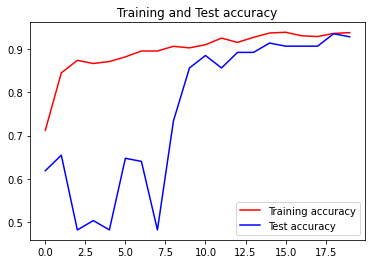

<Figure size 432x288 with 0 Axes>

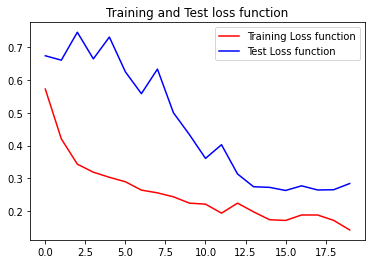

<Figure size 432x288 with 0 Axes>

INFO:tensorflow:Assets written to: model.tf/assets


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0010),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=30, callbacks=[myCallback(), tensorboard_callback])



tf.keras.utils.plot_model(model, to_file='/content/drive/MyDrive/DL_assignment/fcmodel.png', show_shapes=True)
summarize_diagnostics(history)
model.save('model.tf')

In [ ]:
tf.keras.utils.plot_model(model, to_file='/content/drive/MyDrive/DL_assignment/fcmodel.png', show_shapes=True)

In [ ]:
def argmax_plus(d2_array, threshold=0.5, favored=1):
  end_list = []
  for row in d2_array:
    if row[favored]>threshold:
      end_list.append(favored)
    else:
      end_list.append(1-favored)
  return np.array(end_list)

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predIdxs = model.predict(X_valid, batch_size=30)


predIdxs = np.argmax(predIdxs, axis=1)
#predIdxs = argmax_plus(predIdxs, threshold=0.45, favored=1)
print(confusion_matrix(Y_valid, predIdxs))
print(classification_report(Y_valid, predIdxs))

[[118   6]
 [  7  77]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       124
           1       0.93      0.92      0.92        84

    accuracy                           0.94       208
   macro avg       0.94      0.93      0.93       208
weighted avg       0.94      0.94      0.94       208



In [1]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_valid, predIdxs, cmap='Blues')


NameError: ignored

In [ ]:
model.save('/content/drive/MyDrive/GDP/interaction_videos/kpts/NNNN', format)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GDP/interaction_videos/kpts/NNNN/assets
